In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Embedding, Input, Flatten, Dot, Add, Dropout, Concatenate, Dense, Activation, Lambda
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K 


from datetime import datetime

import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [2]:
ratings = pd.read_csv('../data/ml-32m/ratings.csv')
df_users = pd.read_csv('../data/ml-32m/users.csv')
df_movies = pd.read_csv('../data/ml-32m/movies.csv')



In [3]:
#df_movies.loc[df_movies['IMDB URL'].isna(), 'IMDB URL'] = ''

u_unique = ratings.userId.unique()
user2Idx = {o:i+1 for i,o in enumerate(u_unique)}

m_unique = ratings.movieId.unique()
movie2Idx = {o:i+1 for i,o in enumerate(m_unique)}




In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [5]:
ratings.userId = ratings.userId.apply(lambda x: user2Idx[x])

ratings.movieId = ratings.movieId.apply(lambda x: movie2Idx[x])


In [6]:
from sklearn.model_selection import train_test_split
ratings_train, ratings_val = train_test_split(ratings, test_size=0.2)

In [7]:
ratings_train.shape, ratings_val.shape

((25600163, 4), (6400041, 4))

In [8]:
n_users = int(ratings.userId.nunique())
n_movies = int(ratings.movieId.nunique())
n_users_train = int(ratings_train.userId.nunique())
n_movies_train = int(ratings_train.movieId.nunique())
print(n_users, n_movies, n_users_train, n_movies_train)

200948 84432 200948 80170


In [9]:
max_rating = ratings_train['rating'].max()
min_rating = ratings_train['rating'].min()
av_rating = ratings_train['rating'].mean()
max_rating, min_rating, av_rating

(5.0, 0.5, 3.5404372034662437)

In [10]:
#Seteo del experimento
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
mlflow.set_experiment(experiment_name="recommendation_system")

<Experiment: artifact_location='mlflow-artifacts:/331430986844874383', creation_time=1732120321584, experiment_id='331430986844874383', last_update_time=1732120321584, lifecycle_stage='active', name='recommendation_system', tags={}>

In [11]:
mlflow.start_run(run_name="Plot Losses + latent factor 5 + learning_rate 0.0014")

<ActiveRun: >

In [12]:
n_latent_factors = 5
mlflow.log_param("n_latent_factors", n_latent_factors)

5

In [13]:
# l2_reg = l2(0.00025)
movie_embedding_regularizer = 0.001
l2_reg = l2(0.00)
mlflow.log_param("movie_embedding_regularizer_l2", movie_embedding_regularizer)
mlflow.log_param("user_embedding_regularizer_l2", 0.00)
movie_input = Input(shape=[1], name='Item')
movie_embedding = Embedding(n_movies + 1, 
                            n_latent_factors, 
                            embeddings_regularizer = l2(movie_embedding_regularizer),
                            name='Movie-Embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)

m_biases = Flatten(name='movie_biases_flt')(Embedding(n_movies + 1, 1, name="movie_biases", embeddings_regularizer = l2_reg)(movie_input))

user_input = Input(shape=[1],name='User')
user_vec = Flatten(name='FlattenUsers')(Embedding(n_users + 1, n_latent_factors,embeddings_regularizer = l2_reg,name='User-Embedding')(user_input))
u_biases = Flatten(name='user_biases_flt')(Embedding(n_users + 1, 1, name="user_biases", embeddings_regularizer = l2_reg)(user_input))

In [14]:
prod = Dot(axes=1, name='DotProduct')([movie_vec, user_vec])
out = Add()([prod, u_biases, m_biases])
model = Model([user_input, movie_input], out)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Item (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ User (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Movie-Embedding     │ (None, 1, 5)      │    422,165 │ Item[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ User-Embedding      │ (None, 1, 5)      │  1,004,745 │ User[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenMovies       │ (None, 5)         │          0 │ Movie-Embedding[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenUsers        │ (None, 5)         │          0 │ User-Embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_biases         │ (None, 1, 1)      │    200,949 │ User[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_biases        │ (None, 1, 1)      │     84,433 │ Item[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DotProduct (Dot)    │ (None, 1)         │          0 │ FlattenMovies[0]… │
│                     │                   │            │ FlattenUsers[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_biases_flt     │ (None, 1)         │          0 │ user_biases[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_biases_flt    │ (None, 1)         │          0 │ movie_biases[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1)         │          0 │ DotProduct[0][0], │
│                     │                   │            │ user_biases_flt[… │
│                     │                   │            │ movie_biases_flt… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,712,292 (6.53 MB)

 Trainable params: 1,712,292 (6.53 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from fnn_helper import PlotLosses
plot_losses = PlotLosses(1, None)

In [16]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [17]:
learning_rate = 0.0014
model.compile(Adam(learning_rate=learning_rate), 'mean_squared_error', metrics=[root_mean_squared_error])
mlflow.log_param("learning_rate", learning_rate)

0.0014

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='weights1.hdf5.keras', verbose=1, save_best_only=True, monitor='val_root_mean_squared_error')


In [24]:
#from tensorflow.keras.callbacks import ModelCheckpoint
#patience = 5
#early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
#mlflow.log_param("ModelCheckpoint")

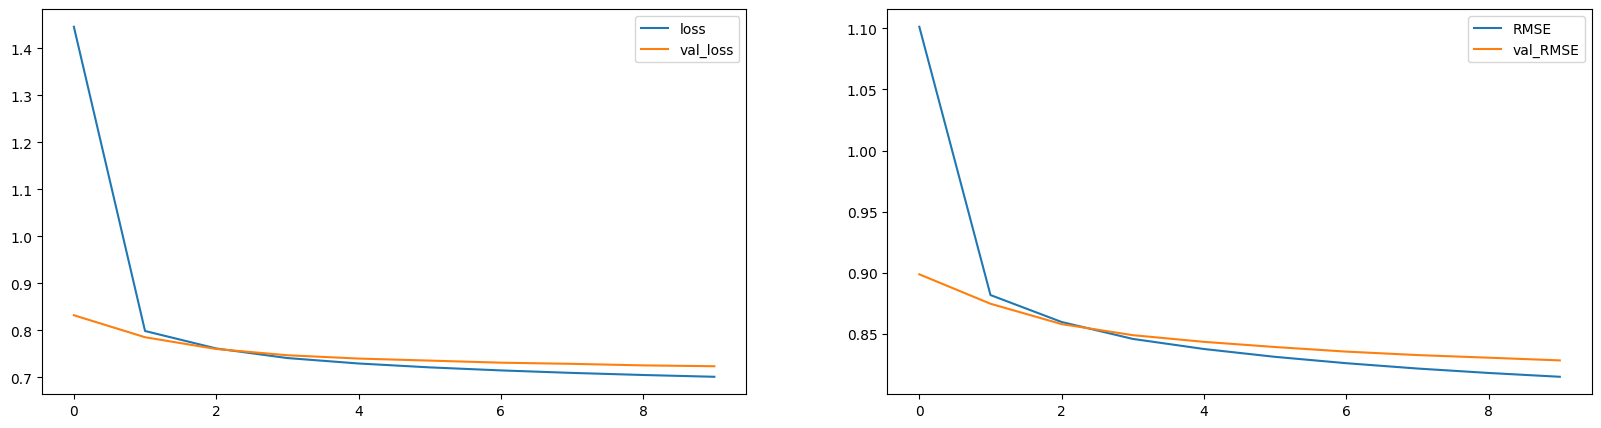


Epoch 10: val_root_mean_squared_error improved from 0.83064 to 0.82842, saving model to weights1.hdf5.keras
80001/80001 ━━━━━━━━━━━━━━━━━━━━ 418s 5ms/step - loss: 0.6989 - root_mean_squared_error: 0.8138 - val_loss: 0.7235 - val_root_mean_squared_error: 0.8284


In [19]:
batch_size = 320
epochs = 10
mlflow.log_param("batch_size", batch_size)
mlflow.log_param("epochs", epochs)

history = model.fit([ratings_train.userId, ratings_train.movieId], 
                    ratings_train.rating, 
                    batch_size=batch_size,
                    validation_data=([ratings_val.userId, ratings_val.movieId], ratings_val.rating), 
                    epochs=epochs, 
                    callbacks = [plot_losses, checkpointer],
                    verbose=1)

In [20]:
for key, value in history.history.items():
  mlflow.log_metric(key, value[-1]) 

In [ ]:
model.evaluate([ratings_val.userId, ratings_val.movieId], ratings_val.rating) # RMSE 0.8186 se puede decir que el modelo performó bastante bien

200002/200002 ━━━━━━━━━━━━━━━━━━━━ 84s 418us/step - loss: 0.7236 - root_mean_squared_error: 0.8186


[0.7234973311424255, 0.8186032176017761]

In [23]:
model.load_weights('weights1.hdf5.keras')
mse, rmse = model.evaluate([ratings_val.userId, ratings_val.movieId], ratings_val.rating)
mlflow.log_metric("val_mse", mse) 
mlflow.log_metric("val_rmse", rmse) 

200002/200002 ━━━━━━━━━━━━━━━━━━━━ 90s 448us/step - loss: 0.7236 - root_mean_squared_error: 0.8186


In [24]:
movie_embeddings_layer = model.layers[2]
user_embeddings_layer = model.layers[3]

movie_embeddings_layer.name, user_embeddings_layer.name

('Movie-Embedding', 'User-Embedding')

In [25]:
mlflow.keras.log_model(model, "best_model")

2024/11/20 15:40:25 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/20 15:40:31 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Luis\AppData\Local\Temp\tmpjl69zlt4\model, flavor: keras). Fall back to return ['keras==3.5.0']. Set logging level to DEBUG to see the full traceback. 


In [26]:
mlflow.end_run()

#### Hay una diferencia de 1 entre n_movies, n_users y  el shape de las matrices de embeddigs

In [ ]:
#movie_embeddings_matrix = movie_embeddings_layer.get_weights()[0]
#user_embeddings_matrix = user_embeddings_layer.get_weights()[0]

#movie_embeddings_matrix.shape, user_embeddings_matrix.shape, n_movies, n_users

((1683, 3), (944, 3), 1682, 943)

In [ ]:
#np.save('../data/vector_db/movie_embeddings_matrix.npy', movie_embeddings_matrix)
#np.save('../data/vector_db/user_embeddings_matrix.npy', user_embeddings_matrix)
#np.save('../data/vector_db/user2Idx.npy', user2Idx)
#np.save('../data/vector_db/movie2Idx.npy', movie2Idx)